In [1]:
import pandas as pd
import importlib
import sys
from tqdm import tqdm
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import contextily as cx
from datetime import datetime, timedelta
from scipy.signal import butter,filtfilt
from scipy.optimize import curve_fit

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
insar_df = insar.get_df()
gnss = GNSS('data/selected_stations_dates.csv')
master_day = insar.get_master_day() # I think that we should completely discard gnss stations that do not have the reference day
gnss.compute_standarized_dataset_up(master_day, unit="mm") #there is a misspelling in the function name but im too lazy to refactor all the changes xds
gnss.compute_and_remove_outliers()
gnss.compute_periodic_function(use_sigma=True)
gnss_df = gnss.get_df()

/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:91: UserWarning: SIM1 does not have data for 6625. Usi

In [4]:
# We will focus on a particular site
site_name = "D931"
site_df = gnss_df[gnss_df["site"] == site_name]
site_gdf = gnss.get_sites_gdf().loc[site_name]
site_lat = site_gdf["_latitude(deg)"]
site_long = site_gdf["_longitude(deg)"]

In [5]:
gnss_df.columns

Index(['site', 'YYMMMDD', 'yyyy.yyyy', '__MJD', 'week', 'd', 'reflon',
       '_e0(m)', '__east(m)', '____n0(m)', '_north(m)', 'u0(m)', '____up(m)',
       '_ant(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)', '__corr_en', '__corr_eu',
       '__corr_nu', '_latitude(deg)', '_longitude(deg)', '__height(m)', 'day',
       'st_up(mm)', 'zscore', 'periodic_func(mm)', 'st_up_no_year(mm)'],
      dtype='object')

In [18]:
def plot_periodic_fit(site_df, periodic, name=None):
    x = pd.to_datetime(site_df["day"], origin='2000-01-01', unit='D')
    y_up = site_df["st_up(mm)"]
    y_up_minus_periodic = y_up - periodic
    
    print(f"MSE: {np.mean(y_up_minus_periodic**2) :.1f}")
    
    fig, ax = plt.subplots()
    fig.set_figwidth(30)
    ax.plot(x,periodic, color = "tab:red", label = "periodic", alpha = 1, lw =2)
    ax.plot(x,y_up_minus_periodic, color = "tab:blue", label="up_minus_periodic", alpha = 0.8, lw =2)
    ax.plot(x,y_up, color = "tab:orange", label="up", alpha = 0.8, lw =2)
    if name is not None:
        ax.set_title(f"{name} fit on GNSS data")
    ax.legend()

In [91]:
def simple_wave(x,a,b,c):
    # right now this is a linear function, but we can try different functions
    return a*np.sin(x*2*np.pi / 365.25) + b*np.cos(x*2*np.pi / 365.25) + c

def half_year_components_wave(x,a,b,c,d,e):
    return a*np.sin(x*2*np.pi / (0.5*365.25)) + b*np.cos(x*2*np.pi / (0.5*365.25)) + simple_wave(x, c,d,e)

def quarter_year_components_wave(x,a,b,c,d,e,f,g):
    return a*np.sin(x*2*np.pi / (0.25*365.25)) + b*np.cos(x*2*np.pi / (0.25*365.25)) + half_year_components_wave(x, c,d,e,f,g)  

def generate_arbitrary_wave(depth, name = "f"):
    # depth = 1 is just intercept
    # depth = 2 is intercept and sinusoids with period of 1 year
    # depth = 3 all of above plus sinusoids of period of half a year
    n_sinusoid_pairs = (depth - 1)
    n_params = n_sinusoid_pairs*2 + 1
    params = [f"x{i}" for i in range(n_params)]
    param_str = ", ".join(["x"] + params)
    
    formula_str = ""
    for i in range(n_sinusoid_pairs):
        period_multiplier = 2**(-i)
        formula_str += f"{params[2*i]}*np.sin(x*2*np.pi / ({period_multiplier}*365.25)) + {params[2*i+1]}*np.cos(x*2*np.pi / ({period_multiplier}*365.25)) + "
    formula_str += f"{params[-1]}"
    
    full_str = f"def {name}("+param_str+"):\n"+"\treturn " + formula_str
    print(full_str)
    return full_str
        
def fit_periodic_function(site_df, f, use_sigma=False):
    x = site_df['day']
    y = site_df['st_up(mm)']
    if use_sigma:
        sigma = site_df['sig_u(m)'] * 1000
        popt, pcov = curve_fit(f, x, y, sigma=sigma)
    else:
        popt, pcov = curve_fit(f, x, y)
    print(f"Condition number of our fit (should be relatively small): {np.linalg.cond(pcov)}")
    return popt, pcov    

Condition number of our fit (should be relatively small): 2.1015645485979206
MSE: 27.1


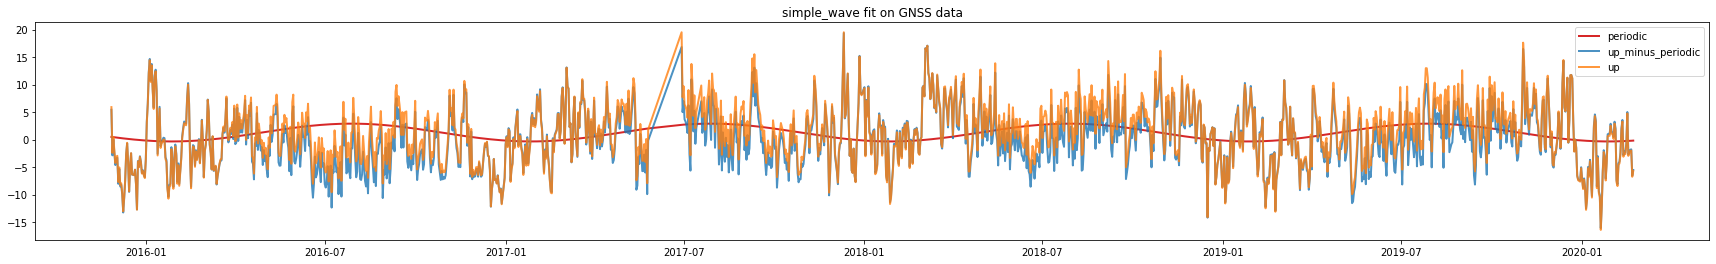

In [86]:
f = simple_wave
popt, pcov = fit_periodic_function(site_df, f, True)
periodic = f(site_df['day'], *popt)
plot_periodic_fit(site_df, periodic, f.__name__)

MSE: 27.1


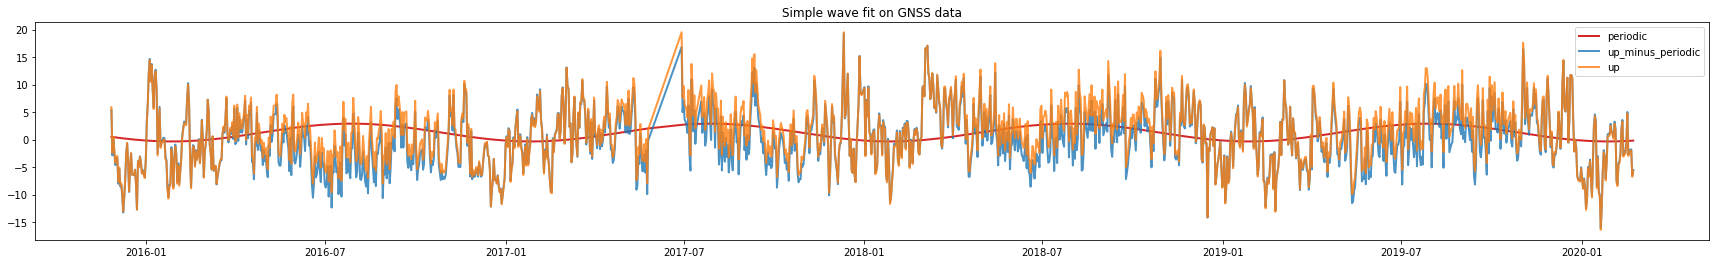

In [87]:
# This is just to check that my computations are correct
plot_periodic_fit(site_df, site_df["periodic_func(mm)"], "Simple wave")

Condition number of our fit (should be relatively small): 2.3441176063757605
MSE: 26.9


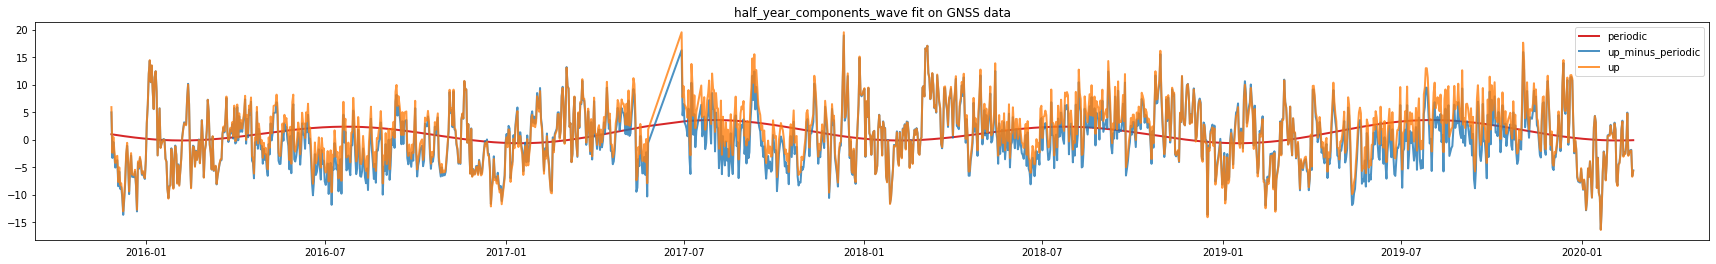

In [22]:
f = half_year_components_wave
popt, pcov = fit_periodic_function(site_df, f, True)
periodic = f(site_df['day'], *popt)
plot_periodic_fit(site_df, periodic, f.__name__)

Condition number of our fit (should be relatively small): 2.3835728699157688
MSE: 26.2


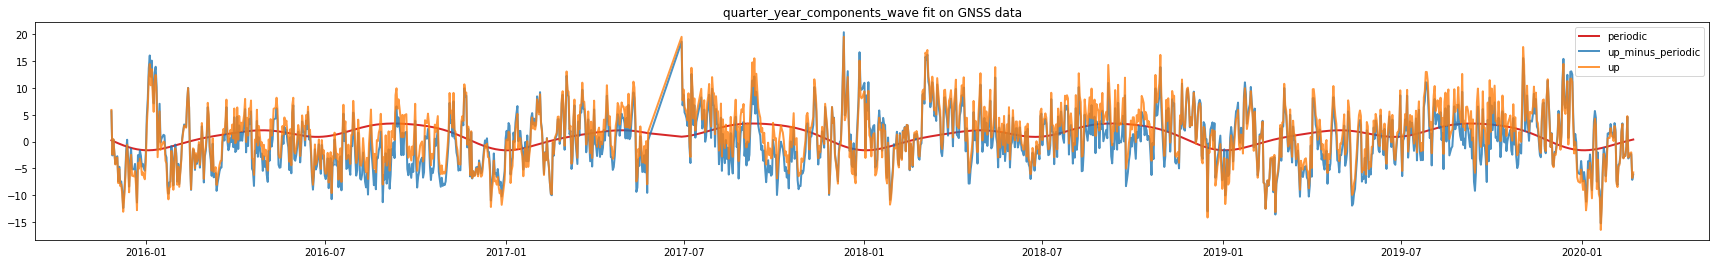

In [88]:
f = quarter_year_components_wave
popt, pcov = fit_periodic_function(site_df, f, True)
periodic = f(site_df['day'], *popt)
plot_periodic_fit(site_df, periodic, f.__name__)

def quarter_fun(x, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49, x50, x51, x52, x53, x54, x55, x56, x57, x58, x59, x60, x61, x62, x63, x64, x65, x66, x67, x68, x69, x70, x71, x72, x73, x74, x75, x76, x77, x78, x79, x80, x81, x82, x83, x84, x85, x86, x87, x88, x89, x90, x91, x92, x93, x94, x95, x96, x97, x98, x99, x100, x101, x102, x103, x104, x105, x106, x107, x108, x109, x110, x111, x112, x113, x114, x115, x116, x117, x118, x119, x120, x121, x122, x123, x124, x125, x126, x127, x128, x129, x130, x131, x132, x133, x134, x135, x136, x137, x138, x139, x140, x141, x142, x143, x144, x145, x146, x147, x148, x149, x150, x151, x152, x153, x154, x155, x156, x157, x158, x159, x160, x161, x162, x163, x164, x165, x166, x167, x168, x169, x170, x171, x172, x173, x174, x175, x176, x177, x178, x179, x180, x181,

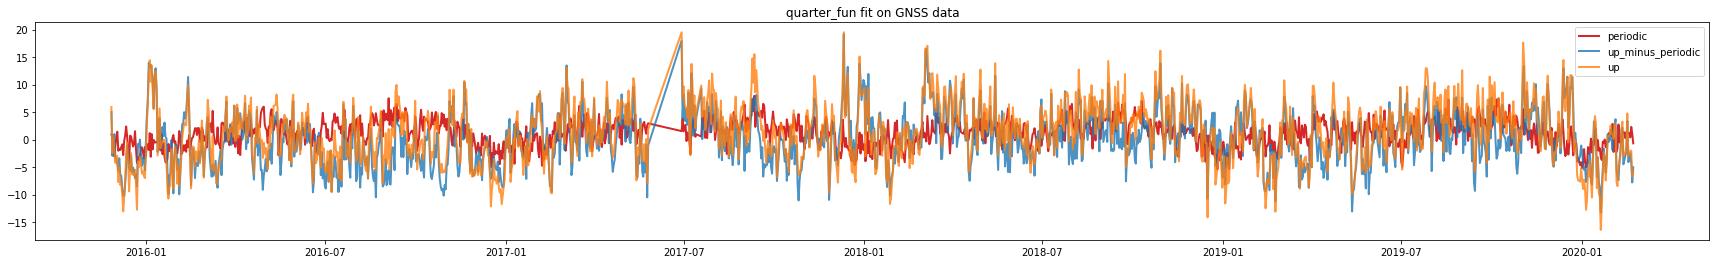

In [95]:
# This is just to check that my arbitrary wave generator is working
f_string = generate_arbitrary_wave(100, name = "quarter_fun")
exec(f_string)
f = quarter_fun
popt, pcov = fit_periodic_function(site_df, f, True)
periodic = f(site_df['day'], *popt)
plot_periodic_fit(site_df, periodic, f.__name__)